# A full MFA analysis workflow

This is a summary notebook of all the MFA methods. More in-depth descriptions, please 

#### INCA script generation

In [1]:
from BFAIR.mfa.INCA import INCA_script
import pandas as pd
import numpy as np
import time
import ast
import matlab.engine

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


#### Initialize the script

In [2]:
INCA_script = INCA_script()

#### Import the data

In [3]:
# measured fragments/MS data, tracers and measured fluxes should be limited to one experiment

atomMappingReactions_data_I = pd.read_csv('data/MFA_modelInputsData/data_stage02_isotopomer_atomMappingReactions2.csv')
modelReaction_data_I = pd.read_csv('data/MFA_modelInputsData/data_stage02_isotopomer_modelReactions.csv')
atomMappingMetabolite_data_I = pd.read_csv('data/MFA_modelInputsData/data_stage02_isotopomer_atomMappingMetabolites.csv')
measuredFluxes_data_I = pd.read_csv('data/MFA_modelInputsData/data_stage02_isotopomer_measuredFluxes.csv')
experimentalMS_data_I = pd.read_csv('data/MFA_modelInputsData/data-1604345289079.csv')
tracer_I = pd.read_csv('data/MFA_modelInputsData/data_stage02_isotopomer_tracers.csv')

#### Exclude data for irreleavnt experiments and models

In [4]:
# The files need to be limited by model id and mapping id, I picked "ecoli_RL2013_02" here
atomMappingReactions_data_I = INCA_script.limit_to_one_model(atomMappingReactions_data_I, 'mapping_id', 'ecoli_RL2013_02')
modelReaction_data_I = INCA_script.limit_to_one_model(modelReaction_data_I, 'model_id', 'ecoli_RL2013_02')
atomMappingMetabolite_data_I = INCA_script.limit_to_one_model(atomMappingMetabolite_data_I, 'mapping_id', 'ecoli_RL2013_02')
measuredFluxes_data_I = INCA_script.limit_to_one_model(measuredFluxes_data_I, 'model_id', 'ecoli_RL2013_02')

# Limiting fluxes, fragments and tracers to one experiment
measuredFluxes_data_I = INCA_script.limit_to_one_experiment(measuredFluxes_data_I, 'experiment_id', 'WTEColi_113C80_U13C20_01')
experimentalMS_data_I = INCA_script.limit_to_one_experiment(experimentalMS_data_I, 'experiment_id', 'WTEColi_113C80_U13C20_01')
tracer_I = INCA_script.limit_to_one_experiment(tracer_I, 'experiment_id', 'WTEColi_113C80_U13C20_01')

## Generate the MATLAB script

Save it in your working directory. The last argument in the script_generator function will name your future .mat file

In [5]:
script = INCA_script.script_generator(
    modelReaction_data_I,
    atomMappingReactions_data_I,
    atomMappingMetabolite_data_I,
    measuredFluxes_data_I,
    experimentalMS_data_I,
    tracer_I
)
INCA_script.save_INCA_script(script, "testscript")
runner = INCA_script.runner_script_generator('TestFile', 10)
INCA_script.save_runner_script(runner=runner, scriptname="testscript")

There is no stoichimetriy given for: ATPM
There is no stoichimetriy given for: Ec_Biomass_INCA
There is no stoichimetriy given for: EX_nh4_LPAREN_e_RPAREN_
There is no stoichimetriy given for: EX_o2_LPAREN_e_RPAREN_
There is no stoichimetriy given for: EX_so4_LPAREN_e_RPAREN_
There is no stoichimetriy given for: FADR_NADH_CYTBD_HYD_ATPS4r
There is no stoichimetriy given for: NADH_CYTBD_HYD_ATPS4r
There is no stoichimetriy given for: NADTRHD_THD2pp
There is no stoichimetriy given for: NADTRHD_THD2pp_reverse


#### Provide the path to you INCA installation, your working directory and the name of the previously generated MATLAB script

In [6]:
INCA_base_directory = "/Users/matmat/Documents/INCAv1.9" # ADD YOUR BASE DIRECTORY HERE, e.g. 
script_folder = %pwd
matlab_script = "testscript"
runner_script = matlab_script + "_runner"

#### INCA will be started and your script run in MATLAB. This will produce the .mat file specified above

In [7]:
INCA_script.run_INCA_in_MATLAB(INCA_base_directory, script_folder, matlab_script, runner_script)

--- 186.927631855011 seconds -


# Reimport MFA data after calculation in INCA

This is an example notebook for the reimport module that is a part of the INCA processing tools of BFAIR. The calculated fluxes/fragments/etc. (other output of INCA), can be reimported and worked on here in Python.

In [8]:
import pandas as pd
import numpy as np
import time
import ast
import sys
import escher
from BFAIR.mfa.INCA import INCA_reimport

In [9]:
filename = 'data/MFA_modelInputsData/TestFile.mat'
simulation_info = pd.read_csv('data/MFA_modelInputsData/Re-import/experimentalMS_data_I.csv')
simulation_id = 'WTEColi_113C80_U13C20_01'

### Stepwise import

In [10]:
reimport_data = INCA_reimport()

In [11]:
# Succession of functions
info = reimport_data.extract_file_info(filename)
parallel, non_stationary = reimport_data.det_simulation_type(simulation_info)
m, f = reimport_data.data_extraction(filename)
model_info = reimport_data.extract_model_info(m)
simulationParameters = reimport_data.extract_sim_params(simulation_id, info, m, filename)
fittedData = reimport_data.extract_base_stats(f, simulation_id, info)
f_mnt_info = reimport_data.get_fit_info(f)
fittedMeasuredFluxes, fittedMeasuredFragments = reimport_data.sort_fit_info(f_mnt_info, simulation_info, fittedData)
f_mnt_res_info = reimport_data.get_residuals_info(f, simulation_info)
fittedMeasuredFluxResiduals, fittedMeasuredFragmentResiduals = reimport_data.sort_residual_info(f_mnt_res_info, simulation_info, fittedData)
f_par_info = reimport_data.get_fitted_parameters(f, simulation_info)
fittedFluxes, fittedFragments = reimport_data.sort_parameter_info(f_par_info, simulation_info, fittedData)

### Alternative shortcut

There is also a summary function that performes all the custom re-import functions subsequently

In [12]:
reimport_data_directly = INCA_reimport()

In [13]:
fittedData2, fittedFluxes2, fittedFragments2, fittedMeasuredFluxes2, fittedMeasuredFragments2, fittedMeasuredFluxResiduals2, fittedMeasuredFragmentResiduals2, simulationParameters2 = reimport_data_directly.reimport(filename, simulation_info, simulation_id)

# Model compatibility

In [14]:
import pandas as pd
import cobra
from BFAIR.mfa.INCA import INCA_reimport
from BFAIR.mfa.sampling import (
    model_rxn_overlap,
    rxn_coverage,
    split_lumped_rxns,
    split_lumped_reverse_rxns,
    find_reverse_rxns,
    combine_split_rxns,
    cobra_add_split_rxns,
    find_biomass_reaction,
    replace_biomass_rxn_name,
)

Here we import the model

In [15]:
model = cobra.io.load_json_model('data/FIA_MS_example/database_files/iJO1366.json')

Academic license - for non-commercial use only - expires 2021-07-30
Using license file /Users/matmat/gurobi.lic


In [16]:
fittedFluxes = replace_biomass_rxn_name(fittedFluxes, biomass_string='Biomass', biomass_rxn_name='BIOMASS_Ec_iJO1366_core_53p95M')

Next step, adjust the names of our MFA data so that they can be assigned to our model's reactions

Observations: 
1) some reaction names include more than one metabolite
2) many unassigned amino acids end with `SYN` and
3) some exchange reactions include `LPAREN_` and `RPAREN_`. Let's try to do something about that
4) probably all `_reverse` reactions could not be assigned

1) Split the lumped reactions and give all of them the same bounds

So let's pick the ones we want. Let's save the reverse reactions for a separate step

In [17]:
lumped_ids = [1, 21, 26, 27, 53, 54, 67, 74, 82]
mask = []
overlap = model_rxn_overlap(fittedFluxes, model)
for i in overlap.iteritems():
    if i[0] in lumped_ids:
        mask.append(True)
    else:
        mask.append(False)

In [18]:
lumped_rxns = model_rxn_overlap(fittedFluxes, model)[mask]
fittedFluxes = split_lumped_rxns(lumped_rxns, fittedFluxes)

In [19]:
lumped_reverse_ids = [2, 28, 55, 68]
mask_reverse = []
for i in model_rxn_overlap(fittedFluxes, model).iteritems():
    if i[0] in lumped_reverse_ids:
        mask_reverse.append(True)
    else:
        mask_reverse.append(False)

In [20]:
lumped_reverse_rxns = model_rxn_overlap(fittedFluxes, model)[mask_reverse]
fittedFluxes = split_lumped_reverse_rxns(lumped_reverse_rxns, fittedFluxes)

ACONTa_ACONTb_reverse
GAPD_PGK_reverse
NADTRHD_THD2pp_reverse
PTAr_ACKr_ACS_reverse


2) SYN, these reactions might be lumped; let's investigate!

In [21]:
for rxn in model.reactions:
    if 'ARG' in rxn.id:
        print(rxn.id)

ARGAGMt7pp
ARGDC
ARGDCpp
ARGORNt7pp
ARGSL
ARGSS
ARGTRS
ARGabcpp
ARGt3pp
ARGtex


3) Let's remove the extra bits in the exchange reaction strings

In [22]:
for i, row in fittedFluxes.iterrows():
    if 'LPAREN_' in row['rxn_id']:
        fittedFluxes.at[i, 'rxn_id'] = row['rxn_id'].replace('LPAREN_', '').replace('_RPAREN_', '')

In [23]:
rxn_coverage(fittedFluxes, model)

50.0 %


4) Reverse. Let's check if the forward and reverse fluxes are actually separate. If not, then the two of them will define the bounds together. If they are, then we should add new reverse reactions to the model.

In [24]:
fittedFluxes, rxns_to_split = combine_split_rxns(fittedFluxes)

These reactions need to be split into two: ACONTa
These reactions need to be split into two: FUM
These reactions need to be split into two: GAPD
These reactions need to be split into two: ICDHyr
These reactions need to be split into two: MlthfSYN
These reactions need to be split into two: PGM
These reactions need to be split into two: PTAr
These reactions need to be split into two: ACONTb
These reactions need to be split into two: PGK
These reactions need to be split into two: ACKr
These reactions need to be split into two: ACS


The reactions that are acutally separate (i.e. non-overlapping bounds) are a problem. COBRA has some ways to account for that but they seem to be quite involved. An easier way to deal with that is that just add the reverse reaction as a separate reaction to the model; it's the same reaction, just with the inverse direction. The following method is "destructive", i.e. it will alter the model. Be aware of that.

In [25]:
cobra_add_split_rxns(rxns_to_split, model)

- Added ACONTa to model
- Added FUM to model
- Added GAPD to model
- Added ICDHyr to model
# Could not add MlthfSYN to model
- Added PGM to model
- Added PTAr to model
- Added ACONTb to model
- Added PGK to model
- Added ACKr to model
- Added ACS to model


In [26]:
rxn_coverage(fittedFluxes, model)

32.0 %


# Sampling

In [27]:
import pickle
import pandas as pd
import escher
import cobra
from cobra import Reaction
from tabulate import tabulate
from gurobipy import Model as GRBModel
from BFAIR.mfa.INCA import INCA_reimport
from BFAIR.mfa.sampling import (
    add_constraints,
    add_feasible_constraints,
    find_biomass_reaction,
    get_min_solution_val,
    replace_biomass_rxn_name,
    bound_relaxation,
)
from BFAIR.mfa.visualization import (
    reshape_fluxes_escher,
)

Let's copy the model so we won't have to go through the pre-processing steps again

In [28]:
model_original = model.copy()

Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmp_chk2sx7.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpmxmauzs1.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros


#### Re-integration

In [29]:
original_solution = model.optimize()

## Dealing with infeasible solutions - exclusion

The easier way to deal with this issue is to simply exclude the constraints that render a model infeasible. We can do that by adding the calculated bounds one by one. If we come across a reaction whose bounds cause trouble, we restart the process and skip this one. This might have to be done a few times to exclude all troublemakers. the `add_feasible_constraints()` functions takes care of that for us. Let's reset the model first.

In [30]:
model = model_original.copy()

Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmp00zj94av.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpumlr_73d.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros


In [31]:
min_val = get_min_solution_val(fittedFluxes, biomass_string='BIOMASS')

In [32]:
model, problems = add_feasible_constraints(model, fittedFluxes, min_val=min_val)

--- start ---
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmps03pnhwe.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpim6mqwqz.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Did not work for 26dap_DASH_MSYN
Did not work for ArgSYN
Solution infeasible if adding ASPTA
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpkrd0zf0i.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros


/Users/matmat/opt/anaconda3/envs/bfair/lib/python3.8/site-packages/cobra/util/solver.py:430: UserWarning: solver status is 'infeasible'
  warn("solver status is '{}'".format(status), UserWarning)


Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpvuxs0hal.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Did not work for 26dap_DASH_MSYN
Did not work for ArgSYN
Solution infeasible if adding DAPDC
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmper_uovdu.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmp6_vqe36_.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Did not work for 26dap_DASH_MSYN
Did not work for ArgSYN
Solution infeasible if adding BIOMASS_Ec_iJO1366_core_53p95M
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmp0s5w3d3i.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmp2a5zg8ta.lp
Reading time = 0.02 seconds
: 1805

The `model` is our newly constrained model and the problematic reactions can be listed in `problems`.

In [33]:
problems

['ASPTA',
 'DAPDC',
 'BIOMASS_Ec_iJO1366_core_53p95M',
 'EX_nh4_e',
 'EX_o2_e',
 'EX_so4_e',
 'GLNS']

Now let's see what an effect these new bounds had on the predicted growth rate (the objective value) of our model

In [34]:
new_bounds_solution = model.optimize()
new_bounds_solution

,fluxes,reduced_costs
EX_cm_e,0.000000,0.0
EX_cmp_e,0.000000,-0.0
EX_co2_e,15.000000,-0.0
EX_cobalt2_e,-0.000020,-0.0
DM_4crsol_c,0.000180,0.0
...,...,...
PTAr_reverse,0.000000,0.0
ACONTb_reverse,0.000000,0.0
PGK_reverse,23.706810,0.0
ACKr_reverse,4.783906,0.0


And here's the star of the show, our sampling method. We trust our models because... we have to! And because smart people that knew what they were doing set them up. So in order to gain more confidence in our MFA data, we sample the model after adding the calculated bound for some of the reactions and re-calculate the fluxes a number of time. Then, we take the mean and take that as the most trustworthy calculated flux. These fluxes can be visualized, for example in tools like `Escher`

In [35]:
sampled_fluxes = cobra.sampling.sample(model, n=100, processes=2)

Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmp7x92cxly.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpkrlck1yf.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros


In [36]:
sampled_fluxes

,EX_cm_e,EX_cmp_e,EX_co2_e,EX_cobalt2_e,DM_4crsol_c,DM_5drib_c,DM_aacald_c,DM_amob_c,DM_mththf_c,EX_colipa_e,...,ACONTa_reverse,FUM_reverse,GAPD_reverse,ICDHyr_reverse,PGM_reverse,PTAr_reverse,ACONTb_reverse,PGK_reverse,ACKr_reverse,ACS_reverse
0,0.0,0.0,14.999088,-1.339147e-06,0.000012,0.000013,0.0,1.115956e-07,0.000075,0.000199,...,2.493187,2.480205,0.000015,2.405819,21.358313,1.039291,2.493187,23.187728,5.067647,0.024882
1,0.0,0.0,14.999084,-1.339510e-06,0.000012,0.000013,0.0,1.116258e-07,0.000076,0.000200,...,2.493826,2.480803,0.000017,2.406503,21.358295,1.039288,2.493826,23.187678,5.067628,0.024827
2,0.0,0.0,14.998737,-1.339462e-06,0.000012,0.000013,0.0,1.116218e-07,0.000460,0.000200,...,2.471987,2.434850,0.000414,2.362223,21.342829,0.997276,2.471987,23.185357,5.088901,0.046730
3,0.0,0.0,14.998857,-1.339745e-06,0.000012,0.000015,0.0,1.116451e-07,0.000460,0.000200,...,2.470665,2.425709,0.000386,2.362204,21.342890,0.996040,2.470665,23.185121,5.088558,0.043674
4,0.0,0.0,14.999487,-1.339599e-06,0.000012,0.000016,0.0,1.116330e-07,0.000460,0.000191,...,2.473141,2.431752,0.000660,2.370946,21.342124,1.003584,2.473141,23.184075,5.079221,0.040048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,14.156739,-5.957167e-07,0.000005,0.000739,0.0,4.950141e-08,0.030364,0.004158,...,18.854177,12.395875,0.904012,8.509575,19.718567,10.244867,18.813388,20.605212,10.661989,14.043184
96,0.0,0.0,14.164929,-3.979189e-07,0.000004,0.000812,0.0,3.327362e-08,0.030274,0.001995,...,19.218672,13.104670,1.042889,9.324296,19.979771,10.366559,19.177943,20.593370,10.525130,13.664941
97,0.0,0.0,14.187878,-4.555902e-07,0.000004,0.000781,0.0,3.790877e-08,0.023998,0.002089,...,19.057096,13.327001,1.023691,9.848673,20.175344,10.980365,19.017571,20.545579,10.227273,13.382844
98,0.0,0.0,14.219565,-4.161341e-07,0.000004,0.000765,0.0,3.481715e-08,0.005227,0.001707,...,18.894520,13.078425,1.056791,9.572593,20.411139,10.631993,18.855104,20.774070,10.187578,13.051384


In [37]:
fluxes_sampling = reshape_fluxes_escher(sampled_fluxes)

In [38]:
sampled_flux_map = escher.Builder('e_coli_core.Core metabolism',
                                  reaction_data = fluxes_sampling).display_in_notebook()
sampled_flux_map

There are also other ways to cosolidate the MFA calculations and the constraint based flux predictions. One of these is lMOMA (linear Minimization Of Metabolic Adjustment). MOMA assumes that the fluxes before and after adding the new constraints should be similar, so it aims to predicting an optimum for the newly constrined model while keeping the differences to the original model small. We suggest using pFBA (parsimonious Flux Balance Analysis) instead of regular FBA for this step as pFBA aims to keep the overal fluxes low.

## Dealing with infeasible solutions - relaxation

Another way of dealing with infeasible models is to relax the added constraints to the point that it works again. You will need to have the Gurobi solver installed for this. The same principle is used in the `BFAIR thermo` tools. For that we add our constraints to a model that will now be infeasible. Have I meantioned that this is much more elegant, better and that you should do that? It is. The other method is *fine* but you exclude reactions and, in general, it is always better to use as much as possible of the information that is available to you.

In [39]:
model = model_original.copy()

Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpvqr73dw6.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmphajgz79_.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros


In [40]:
model = add_constraints(model, fittedFluxes)

--- start ---
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmp56xf2ylp.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmp64r6tsdy.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Did not work for 26dap_DASH_MSYN
Did not work for ArgSYN
Did not work for EX_co2_e_unlabeled
Did not work for EX_glc_e
Did not work for FADR
Did not work for GluSYN
Did not work for HisSYN
Did not work for IleSYN
Did not work for LeuSYN
Did not work for MetSYN
Did not work for MlthfSYN
Did not work for MlthfSYN_reverse
Did not work for NADH
Did not work for PheSYN
Did not work for ProSYN
Did not work for SerSYN
Did not work for SUCCOAS
Did not work for ThrSYN
Did not work for TKT1a
Did not work for TKT1b
Did not work for TKT2a
Did not work for TKT2b
Did not work for TrpSYN
Did not work for TyrSYN
Did not work for ValSYN
Did not work for CYTBD
Did n

In [41]:
model.optimize()

/Users/matmat/opt/anaconda3/envs/bfair/lib/python3.8/site-packages/cobra/util/solver.py:430: UserWarning: solver status is 'infeasible'
  warn("solver status is '{}'".format(status), UserWarning)


<Solution infeasible at 0x7fb094311d00>

Then we make use of the handy `bound_relaxation()` function that will test our model to figure out which of these added bounds need to be adjusted and return a DataFrame that describes the affected functions and the gravity of the suggested changes. If we allow this function to be `desctructive` it will adjust the input model right away.

In [42]:
cons_table = bound_relaxation(model, fittedFluxes, destructive=True, fluxes_to_ignore=['BIOMASS_Ec_iJO1366_core_53p95M'])
cons_table

--- start ---
bound_relaxation takes 0h: 0min: 0sec to run
--- end ---


,lb_change,ub_change,subsystem
reaction,,,
EX_o2_e,-16.610505,0.000000,Extracellular exchange
ASPTA,-3.865062,0.000000,Alanine and Aspartate Metabolism
GLNS,0.000000,0.767431,Glutamate Metabolism
EX_nh4_e_reverse_f9cc6,0.000000,12.360577,Extracellular exchange
EX_so4_e_reverse_5c8ed,0.000000,0.376547,Extracellular exchange
DAPDC_reverse_d3ab8,-0.040213,0.000000,Threonine and Lysine Metabolism


Let's see if our model is feasible now.

In [43]:
relaxed_solution = model.optimize()
relaxed_solution

,fluxes,reduced_costs
EX_cm_e,0.000000,0.0
EX_cmp_e,0.000000,-0.0
EX_co2_e,14.698232,0.0
EX_cobalt2_e,-0.000017,-0.0
DM_4crsol_c,0.000156,0.0
...,...,...
PTAr_reverse,0.000000,0.0
ACONTb_reverse,0.000000,0.0
PGK_reverse,23.033030,0.0
ACKr_reverse,4.865707,0.0


In [44]:
relaxed_solution.fluxes["BIOMASS_Ec_iJO1366_core_53p95M"]

0.7

And here's the star of the show, our sampling method. We trust our models because... we have to! And because smart people that knew what they were doing set them up. So in order to gain more confidence in our MFA data, we sample the model after adding the calculated bound for some of the reactions and re-calculate the fluxes a number of time. Then, we take the mean and take that as the most trustworthy calculated flux. These fluxes can be visualized, for example in tools like `Escher`.
So here is the point where we can let the power of constraint based models work for us and make use of the tools mentioned above in order to adjust the fluxes calculated using MFA so that they nicely fit into our model.

In [45]:
relaxed_sampled_fluxes = cobra.sampling.sample(model, n=100, processes=2)

Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpdxjoiq2r.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpwimsstip.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros


In [46]:
relaxed_fluxes_sampling = reshape_fluxes_escher(relaxed_sampled_fluxes)

In [47]:
relaxed_flux_map = escher.Builder('e_coli_core.Core metabolism',
                                  reaction_data = relaxed_fluxes_sampling).display_in_notebook()
relaxed_flux_map

## Alternatives

There are also other ways to cosolidate the MFA calculations and the constraint based flux predictions. 

#### MOMA

One of these is lMOMA (linear Minimization Of Metabolic Adjustment). MOMA assumes that the fluxes before and after adding the new constraints should be similar, so it aims to predicting an optimum for the newly constrined model while keeping the differences to the original model small. We suggest using pFBA (parsimonious Flux Balance Analysis) instead of regular FBA for this step as pFBA aims to keep the overal fluxes low.

From [Volkova, 2020](https://www.mdpi.com/2218-1989/10/8/303/htm):

"While FBA with the objective of maximizing growth results in reasonable solutions for wild-type cells, it does not so for (unevolved) gene knockout mutants. While in principle wild-type cells optimize their growth, unevolved cells with knockouts do not. Since homeostasis governs metabolic reprogramming, we cannot assume that the cell will follow a common objective, such as maximizing its growth. To acknowledge the requirement for metabolic homeostasis, the minimization of metabolic adjustment (MOMA) approach was proposed. The main idea behind this method is that, to maintain homeostasis, the difference in fluxes before and after the perturbation should be minimal. MOMA predicts the fluxes of a knockout strain by assuming that the cell will have a minimal redistribution of fluxes compared to its ancestor."
We're using pFBA istead of FBA because, on top of optimizing the growth rate, it also minimizes the total sum of fluxes.

In [48]:
pfba_relaxed_solution = cobra.flux_analysis.pfba(model)

In [49]:
moma_after_relaxed_MFA = cobra.flux_analysis.moma(
    model=model, solution=pfba_relaxed_solution, linear=True)

In [50]:
moma_after_relaxed_MFA.fluxes["BIOMASS_Ec_iJO1366_core_53p95M"]

0.7

#### ROOM

From [Volkova, 2020](https://www.mdpi.com/2218-1989/10/8/303/htm):

Another similar approach is the regulatory on/off minimization (ROOM), which minimizes the number of fluxes that are significantly different from the wild type. Wild-type fluxes, determined by FBA or other methods, need to be known in order to use these approaches. 

In [51]:
room_after_relaxed_MFA = cobra.flux_analysis.room(
    model=model, solution=pfba_relaxed_solution, linear=True, delta=0.03, epsilon=0.001)

In [52]:
room_after_relaxed_MFA.fluxes["BIOMASS_Ec_iJO1366_core_53p95M"]

0.7

In [53]:
from tabulate import tabulate
results = [['Before adding new constraints:', round(original_solution.objective_value, 2)],
           ['New constraints relaxed FBA:', round(relaxed_solution.objective_value, 2)],
           ['New constraints relaxed pFBA:', round(pfba_relaxed_solution.fluxes["BIOMASS_Ec_iJO1366_core_53p95M"], 2)],
           ['New constraints relaxed MOMA:', round(moma_after_relaxed_MFA.fluxes["BIOMASS_Ec_iJO1366_core_53p95M"], 2)],
           ['New constraints relaxed ROOM:', round(room_after_relaxed_MFA.fluxes["BIOMASS_Ec_iJO1366_core_53p95M"], 2)]]
print(tabulate(results, headers=["Method", "Biomass function"]))

Method                            Biomass function
------------------------------  ------------------
Before adding new constraints:                0.98
New constraints relaxed FBA:                  0.7
New constraints relaxed pFBA:                 0.7
New constraints relaxed MOMA:                 0.7
New constraints relaxed ROOM:                 0.7


Of course also the MOMA results can be visualized with `Escher`. The `reshape_fluxes_escher()` can take both pandas DataFrames or cobra solutions as an input.

In [54]:
fluxes_relaxed_moma = reshape_fluxes_escher(moma_after_relaxed_MFA)
moma_relaxed_flux_map = escher.Builder('e_coli_core.Core metabolism',
                                       reaction_data = fluxes_relaxed_moma).display_in_notebook()
moma_relaxed_flux_map

In [55]:
fluxes_relaxed_room = reshape_fluxes_escher(room_after_relaxed_MFA)
room_relaxed_flux_map = escher.Builder('e_coli_core.Core metabolism',
                                       reaction_data = fluxes_relaxed_room).display_in_notebook()
room_relaxed_flux_map

# Pathway visualization

In [56]:
from BFAIR.mfa.INCA import INCA_reimport
from BFAIR.mfa.utils import (
    calculate_split_ratio,
    plot_split_ratio,
    get_observable_fluxes,
    percent_observable_fluxes,
    get_flux_precision,
)
from BFAIR.mfa.visualization import (
    reshape_fluxes_escher,
    sampled_fluxes_minrange,
    show_reactions,
    plot_sampled_reaction_fluxes,
    plot_all_subsystem_fluxes,
    get_subsytem_reactions,
    show_subsystems,
    plot_subsystem_fluxes,
)

The following steps are detailed in the notebooks `MFA_compatibility` and `MFA_feasibility_and_sampling`.

In [57]:
model = model_original.copy()

Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmp79wklwb_.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmp71xdwkpz.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros


## Investigate the sampled fluxes

A few plots of the distribution of points per reaction to visually inspect how gaussian the sample distributions are. In rare cases, bimodal distributions can be found

#### Sampled value distributions per reaction

In [58]:
reactions, _ = get_subsytem_reactions(model, 14)

In [59]:
show_reactions(reactions)

0: ACALD
1: ACKr
2: ACS
3: ALCD2x
4: FHL
5: LDH_D
6: OAADC
7: PFL
8: POR5
9: PTAr
10: PTAr_reverse
11: ACKr_reverse
12: ACS_reverse


Here are some plotting methods to better understand what we just created. These plots include a check for normal distributions; if the sampled fluxes for a reaction are normal distributed, we see a green histogram with a kernel density distribution in red. If they are not then the colors are inverted. Here are some examples:

Reaction with normally distributed sampled fluxes:

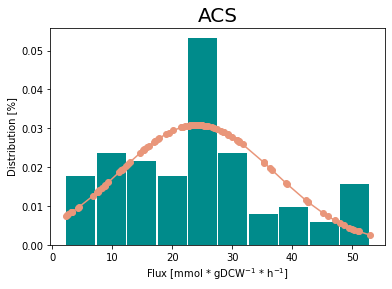

In [60]:
plot_sampled_reaction_fluxes(relaxed_sampled_fluxes, reactions, reaction_id=2)

No normal distribution:

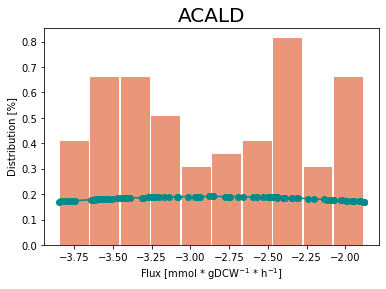

In [61]:
plot_sampled_reaction_fluxes(relaxed_sampled_fluxes, reactions, reaction_id=0)

We can also produce a summary plot for all the sampled reactions in a selected subsystem:

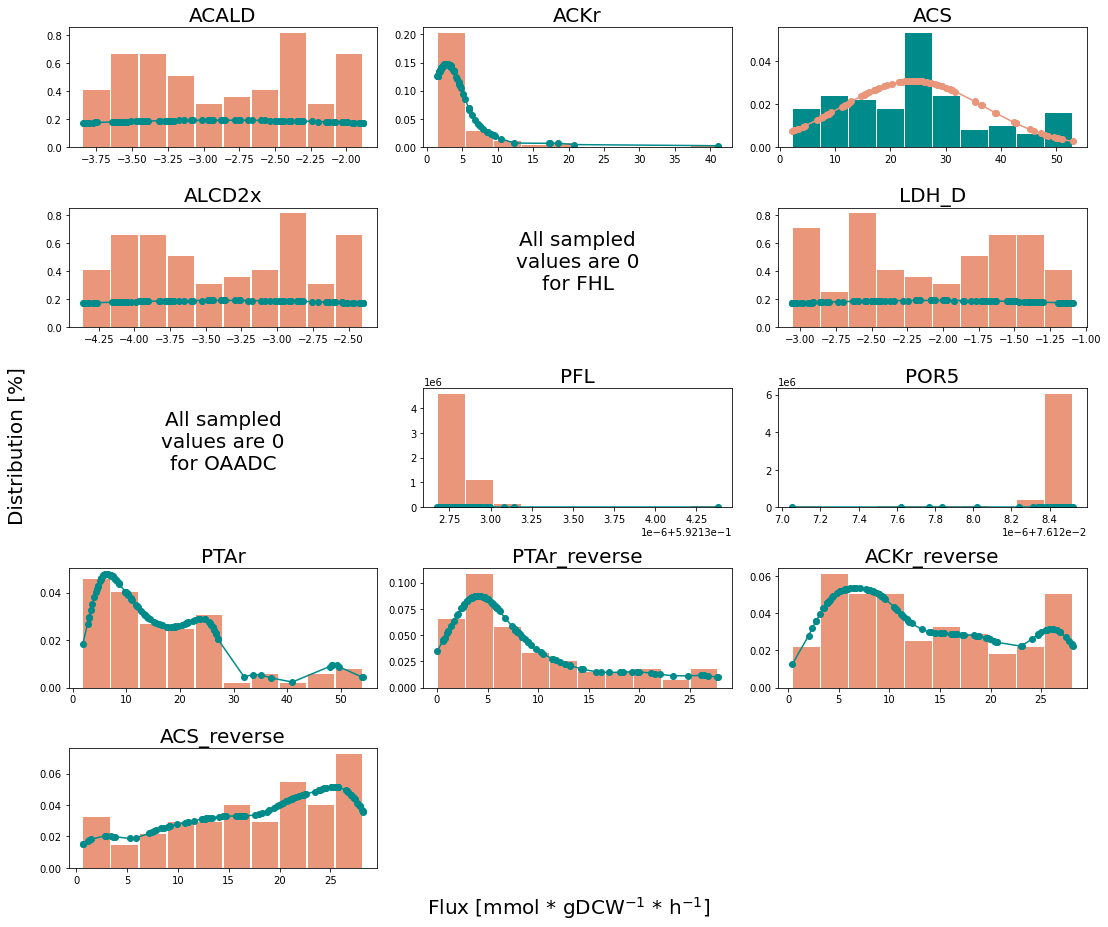

In [62]:
_ = plot_all_subsystem_fluxes(relaxed_sampled_fluxes, reactions, bins=10)

#### Box plots for several reactions of interest to visualize the distribution of points

This is a different way to have a look at the distributions of sampled values for a selected subsystem

We can exclude some reactions if their sampled fluxes are very small in order not to crowd the plot. Here we exclude every reaction whose max value does not exceed 1 and whose min value does not go below -1

In [63]:
reduced_relaxed_sampled_fluxes = sampled_fluxes_minrange(relaxed_sampled_fluxes, min_val=-1, max_val=1)

In [64]:
reduced_relaxed_sampled_fluxes

,EX_co2_e,EX_glc__D_e,EX_h_e,EX_h2o_e,EX_ac_e,EX_lac__D_e,EX_nh4_e,EX_o2_e,EX_etoh_e,ABUTt2pp,...,ACONTa_reverse,FUM_reverse,GAPD_reverse,ICDHyr_reverse,PGM_reverse,PTAr_reverse,ACONTb_reverse,PGK_reverse,ACKr_reverse,ACS_reverse
0,14.244331,-10.0,10.252011,28.789645,2.3,1.514657,-7.560577,-8.810505,3.938788,222.778481,...,11.995176,8.226120,5.282246,4.631473,21.994701,5.892110,11.831156,23.216858,3.963411,12.370337
1,13.674453,-10.0,10.821889,28.789570,2.3,2.084384,-7.560577,-8.810505,3.368986,339.844829,...,19.987363,14.250059,9.377489,8.372610,23.261627,7.919368,19.720632,23.391057,15.054774,14.716577
2,14.437991,-10.0,10.058351,28.789693,2.3,1.321094,-7.560577,-8.810505,4.132400,50.318682,...,26.158884,25.258850,21.042297,23.182588,29.012398,2.538858,26.104460,24.181721,2.738818,25.692763
3,13.480835,-10.0,11.015507,28.789662,2.3,2.278187,-7.560577,-8.810505,3.175274,300.773338,...,19.746611,16.264287,9.232993,12.597959,24.453434,9.756829,19.648964,23.554909,7.856518,20.172503
4,13.701781,-10.0,10.794560,28.789548,2.3,2.057013,-7.560577,-8.810505,3.396335,411.001516,...,23.467428,14.309197,10.487260,7.569883,22.522553,6.187061,23.238912,23.289447,14.549335,19.759520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,13.162564,-10.0,11.333777,28.789541,2.3,2.596215,-7.560577,-8.810505,2.857126,666.584976,...,23.789606,22.545615,17.733685,3.275045,21.520194,4.707482,23.649052,23.151637,5.624934,21.937299
96,13.021956,-10.0,11.474385,28.789562,2.3,2.736865,-7.560577,-8.810505,2.716497,876.504743,...,25.344010,17.005184,13.075038,1.164240,20.821961,3.420676,25.055496,23.055631,11.147361,24.027935
97,14.566332,-10.0,9.930010,28.789705,2.3,1.192777,-7.560577,-8.810505,4.260729,26.818849,...,1.254168,0.849726,0.477905,0.204772,20.912499,0.578815,1.237438,23.068059,5.158539,1.153175
98,14.597348,-10.0,9.898994,28.789705,2.3,1.161760,-7.560577,-8.810505,4.291745,35.339544,...,1.907085,1.340139,0.862518,0.905312,21.059885,1.103906,1.917119,23.088322,6.138964,1.294993


Here is the pyruvate metabolism as an example

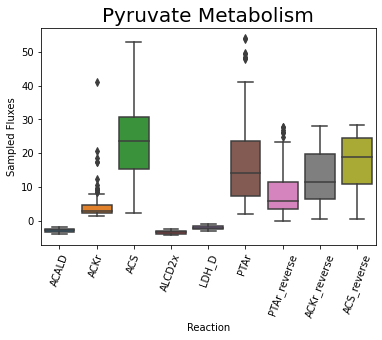

In [65]:
plot_subsystem_fluxes(model, reduced_relaxed_sampled_fluxes, subsystem_id=14, no_zero_cols=True)

#### Calculating the flux splits at key branch points

One important piece of information that can be extracted from calculated fluxes are the flux splits at branching points (e.g., glycolysis vs. PPP, TCA vs. acetate secretion, glyoxylate shunt vs. full TCA, etc.). This will provide information about which of the optional pathways branching off of a given intermediate will carry a higher flux that potentially interferes with a mapped out production strategy. Escher Maps as seen above can be used in order to identify the reactions leading to- and branching off these intermediates. Here we present the following splits as examples:

- Glycolysis/PPP: `EX_glc__D` compared to `PGI` and `G6PDH2r`
- Glyoxylate shunt/full TCA: `ACONTb` compared to `ICDHyr` and `ICL`
- TCA/acetate secretion: (`ACALD`, `PFL`, `PDH`) compared to `PTAr` and `CS`

These fluxes can either be single fluxes, selected by their IDs (see the first two examples) or a combination of multiple fluxes (see last example)

,Mean,Stdev
EX_glc__D_e/G6PDH2r,0.474611,0.000004
EX_glc__D_e/PGI,0.433008,0.069793


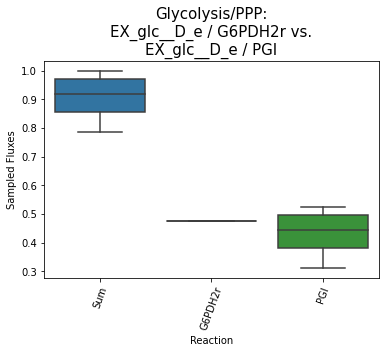

In [66]:
plot_split_ratio(relaxed_sampled_fluxes, 'EX_glc__D_e', 'G6PDH2r', 'PGI', branch_point_name="Glycolysis/PPP")
calculate_split_ratio(relaxed_sampled_fluxes, 'EX_glc__D_e', 'G6PDH2r', 'PGI', branch_point_name="Glycolysis/PPP")

,Mean,Stdev
ACONTb/ICDHyr,5.123180e-01,2.516308e-01
ACONTb/ICL,4.641178e-09,1.092640e-08


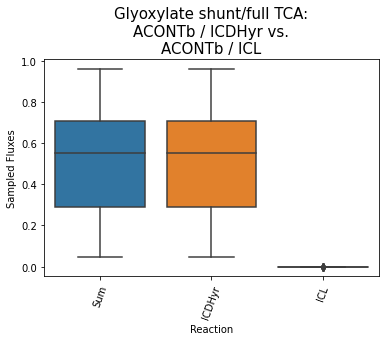

In [67]:
plot_split_ratio(relaxed_sampled_fluxes, 'ACONTb', 'ICDHyr', 'ICL', branch_point_name="Glyoxylate shunt/full TCA")
calculate_split_ratio(relaxed_sampled_fluxes, 'ACONTb', 'ICDHyr', 'ICL', branch_point_name="Glyoxylate shunt/full TCA")

,Mean,Stdev
Glycolysis/PTAr,1.473740,0.991504
Glycolysis/CS,0.121342,0.012703


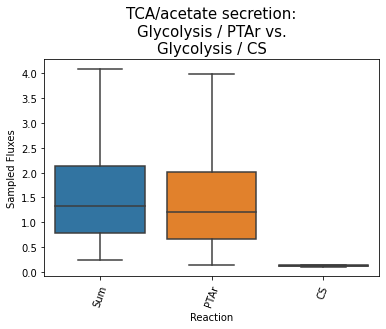

In [68]:
glycolysis = abs(relaxed_sampled_fluxes['ACALD']) + abs(relaxed_sampled_fluxes['PFL']) + abs(relaxed_sampled_fluxes['PDH'])
glycolysis.name = 'Glycolysis'
plot_split_ratio(relaxed_sampled_fluxes, glycolysis, 'PTAr', 'CS', branch_point_name="TCA/acetate secretion")
calculate_split_ratio(relaxed_sampled_fluxes, glycolysis, 'PTAr', 'CS', branch_point_name="TCA/acetate secretion")

#### Calculating the flux resolution

First we want to calculate which fluxes qualify as "observable fluxes", i.e. flux value at least 4 times the confidence interval and 0 not included in the confidence interval.

In [69]:
relaxed_sampled_fluxes

,EX_cm_e,EX_cmp_e,EX_co2_e,EX_cobalt2_e,DM_4crsol_c,DM_5drib_c,DM_aacald_c,DM_amob_c,DM_mththf_c,EX_colipa_e,...,ACONTa_reverse,FUM_reverse,GAPD_reverse,ICDHyr_reverse,PGM_reverse,PTAr_reverse,ACONTb_reverse,PGK_reverse,ACKr_reverse,ACS_reverse
0,0.0,0.0,14.244331,-0.000017,0.000156,0.000157,0.0,0.000001,0.000314,4.246613e-12,...,11.995176,8.226120,5.282246,4.631473,21.994701,5.892110,11.831156,23.216858,3.963411,12.370337
1,0.0,0.0,13.674453,-0.000018,0.000156,0.000157,0.0,0.000001,0.000314,-7.712807e-13,...,19.987363,14.250059,9.377489,8.372610,23.261627,7.919368,19.720632,23.391057,15.054774,14.716577
2,0.0,0.0,14.437991,-0.000018,0.000156,0.000158,0.0,0.000001,0.000314,-1.989870e-13,...,26.158884,25.258850,21.042297,23.182588,29.012398,2.538858,26.104460,24.181721,2.738818,25.692763
3,0.0,0.0,13.480835,-0.000017,0.000156,0.000158,0.0,0.000001,0.000314,2.140148e-12,...,19.746611,16.264287,9.232993,12.597959,24.453434,9.756829,19.648964,23.554909,7.856518,20.172503
4,0.0,0.0,13.701781,-0.000018,0.000156,0.000157,0.0,0.000001,0.000314,-8.604056e-13,...,23.467428,14.309197,10.487260,7.569883,22.522553,6.187061,23.238912,23.289447,14.549335,19.759520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,13.162564,-0.000018,0.000156,0.000158,0.0,0.000001,0.000314,-2.559196e-13,...,23.789606,22.545615,17.733685,3.275045,21.520194,4.707482,23.649052,23.151637,5.624934,21.937299
96,0.0,0.0,13.021956,-0.000018,0.000156,0.000158,0.0,0.000001,0.000314,-1.927370e-12,...,25.344010,17.005184,13.075038,1.164240,20.821961,3.420676,25.055496,23.055631,11.147361,24.027935
97,0.0,0.0,14.566332,-0.000017,0.000156,0.000157,0.0,0.000001,0.000314,1.112339e-12,...,1.254168,0.849726,0.477905,0.204772,20.912499,0.578815,1.237438,23.068059,5.158539,1.153175
98,0.0,0.0,14.597348,-0.000017,0.000156,0.000158,0.0,0.000001,0.000314,1.488700e-12,...,1.907085,1.340139,0.862518,0.905312,21.059885,1.103906,1.917119,23.088322,6.138964,1.294993


In [70]:
observable_fluxes = get_observable_fluxes(fittedFluxes)

In [71]:
observable_fluxes

,index,simulation_id,simulation_dateAndTime,rxn_id,flux,flux_stdev,flux_lb,flux_ub,flux_units,fit_alf,fit_chi2s,fit_cor,fit_cov,free,used_,comment_
0,0,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,26dap_DASH_MSYN,0.229504,0.002608,0.224392,0.234616,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
4,4,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,ALATA_L,0.343552,0.003904,0.335900,0.351204,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
5,5,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,ArgSYN,0.197824,0.002248,0.193418,0.202230,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
6,6,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,ASNN,0.161216,0.001832,0.157625,0.164807,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
7,7,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,ASPTA,1.279872,0.014544,1.251366,1.327850,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
10,10,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,DAPDC,0.229504,0.002608,0.224392,0.234616,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
11,11,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,BIOMASS_Ec_iJO1366_core_53p95M,0.704000,0.008000,0.688320,0.719680,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
14,14,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,EX_ac_e,2.130000,0.500000,1.917000,2.343000,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
17,17,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,EX_glc_e,7.400000,0.200000,7.007922,7.791993,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
18,18,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,EX_nh4_e,4.901952,0.055704,4.792774,5.011130,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None


The following amount of fluxes qualifies as being observalbe

In [72]:
percent_observable_fluxes(fittedFluxes)

27.72 %


The flux precision is defined as the mean of the standard deviations of the fitted Fluxes

In [73]:
get_flux_precision(fittedFluxes)

0.031311574686820484